In [2]:
# Import commonly used libraries
import numpy as np
import pandas as pd
from datetime import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
%matplotlib inline
import cvxopt as opt
from cvxopt import blas, solvers

For the capstone project I am going to review a portfolio of utility stocks. They are old, tried and true investments. I'll take a look at what mix of utility assets produces the best efficiency curve. I'll start by doing so basic return analysis, variance of the returns, the return average by stock, and finally calculate some covariance. 

The fun will then begin by building the efficiency curves. I'll create an array of combinations of the different stocks. From there I will plot each of the efficiency curves to see what the maximum, minimum, and the most efficient curves. Finally, I'll find the mix of stocks that produces that curve.

In [3]:
# list of utility stocks gathered from the internet
#UNCOMMENT TO PULL DATA

#symbols = ['AQN', 'AT', 'AGR', 'AZRE', 'BKH', 'BEP',\
#           'CNP', 'EBR', 'CEPU', 'CWEN', 'CIG', 'ELP', \
#           'CVA', 'D', 'DTE', 'EIX', 'ELLO', 'EDN', 'ENIA',\
#          'ENIC', 'ETR', 'ES', 'FE', 'FTS', 'HE', 'HNP', \
#           'IDA', 'KEN', 'KEP','NEE', 'NRG', 'OGE', 'ORA', \
#           'PAM', 'PNW', 'PNM', 'POR', 'PPL', 'SO', 'TVE', \
#           'TVC', 'AES', 'TAC', 'VST']

#start_date = datetime(2015, 1, 1)
#end_date = datetime(2021, 7, 1)

# stock_data = web.get_data_yahoo(symbols, start_date, end_date)
# stock_data.to_csv(index = False)

In [4]:
#stock_data.to_csv('stock_data.csv',index = False)

stock_data = pd.read_csv('stock_data.csv')
stock_data.head()

,Adj Close,Adj Close.1,Adj Close.2,Adj Close.3,Adj Close.4,Adj Close.5,Adj Close.6,Adj Close.7,Adj Close.8,Adj Close.9,...,Volume.34,Volume.35,Volume.36,Volume.37,Volume.38,Volume.39,Volume.40,Volume.41,Volume.42,Volume.43
0,AQN,AGR,AZRE,BKH,BEP,CNP,EBR,CEPU,CWEN,CIG,...,PNM,POR,PPL,SO,TVE,TVC,AES,TAC,VST,AT
1,6.046732425689697,NaN,NaN,42.918426513671875,11.492673873901367,18.000553131103516,1.9465845823287964,NaN,NaN,3.230569839477539,...,487400.0,783300.0,4041765.0,4645300.0,2400.0,5000.0,5228700.0,158400.0,NaN,NaN
2,6.061392307281494,NaN,NaN,42.07007598876953,11.720179557800293,17.42922592163086,1.8556225299835205,NaN,NaN,3.0670793056488037,...,539700.0,761300.0,5920013.0,7028700.0,12400.0,11600.0,5411400.0,204300.0,NaN,NaN
3,6.0027570724487305,NaN,NaN,41.25404739379883,11.577069282531738,17.040729522705078,1.810141682624817,NaN,NaN,3.0392091274261475,...,436700.0,957500.0,5634529.0,9358300.0,14700.0,26000.0,7171200.0,129600.0,NaN,NaN
4,6.0027570724487305,NaN,NaN,41.464107513427734,11.474327087402344,17.261640548706055,1.9647769927978516,NaN,NaN,3.1055679321289062,...,549500.0,695500.0,4335839.0,4917000.0,10300.0,14600.0,4932000.0,177700.0,NaN,NaN


So looking at the dataframe from the CSV file, the headers are the type of close and the stock symbols are the first row. I also got an error trying to import data on AT. That data is the last column of each returned feature such as open, close, adjusted close, etc. 

How I will handle this is removing the stock symbol from the first row. Then I will create a function to rename the column headings to the stock symbol. From there I can start creating some graphs to visualize the data. 

In [5]:
#create dataframes for making it easy to process from original dataframe and CSV 
adjusted_close = stock_data.iloc[1:,0:43]  # remove the stock symbol and get adjusted close values
close_df = stock_data.iloc[1:,44:87]  # remove the stock symbol and get close values
high_df = stock_data.iloc[1:,88:131]  # remove the stock symbol and get high values
low_df = stock_data.iloc[1:,132:175]  # remove the stock symbol and get low values
open_df = stock_data.iloc[1:,176:219]  # remove the stock symbol and get open values
volume_df = stock_data.iloc[1:,220:263]  # remove the stock symbol and get volume values
#print(adjusted_close)
symbols = ['AQN', 'AGR', 'AZRE', 'BKH', 'BEP',\
           'CNP', 'EBR', 'CEPU', 'CWEN', 'CIG', 'ELP', \
           'CVA', 'D', 'DTE', 'EIX', 'ELLO', 'EDN', 'ENIA',\
          'ENIC', 'ETR', 'ES', 'FE', 'FTS', 'HE', 'HNP', \
           'IDA', 'KEN', 'KEP','NEE', 'NRG', 'OGE', 'ORA', \
           'PAM', 'PNW', 'PNM', 'POR', 'PPL', 'SO', 'TVE', \
           'TVC', 'AES', 'TAC', 'VST']

# reassign headings with created dictionary
def rename_columns(dataframe, name_string):
    adj_close_dict = {}
    for i in range(len(symbols)):
        if i > 0:
            adj_close_dict[name_string +'.'+ str(i)] = symbols[i]
        else:
            adj_close_dict[name_string] = symbols[i]
    #print(adj_close_dict) # Uncomment to see dictionary
    dataframe.rename(columns = adj_close_dict, inplace = True)

#Rename Columns in Dataframe with rename columns function
rename_columns(adjusted_close,'Adj Close')
rename_columns(close_df,'Close')
rename_columns(high_df,'High')
rename_columns(low_df,'Low')
rename_columns(open_df,'Open')
rename_columns(volume_df,'Volume')

#Remove NaN to remove strings from DF
#adjusted_close_zero = adjusted_close.fillna(0, inplace = True)
#close_df.fillna(0, inplace = True)
#high_df.fillna(0, inplace = True)
#low_df.fillna(0, inplace = True)
#open_df.fillna(0, inplace = True)
#volume_df.fillna(0, inplace = True)

#Uncomment to display the head of each dataframe
# print(adjusted_close.head(),"\n\n", close_df.head(), "\n\n",high_df.head(), \
#      "\n\n",low_df.head(), "\n\n",open_df.head(), "\n\n",volume_df.head())

Text(0.5, 1.0, 'Utility Stocks Adjusted Price')

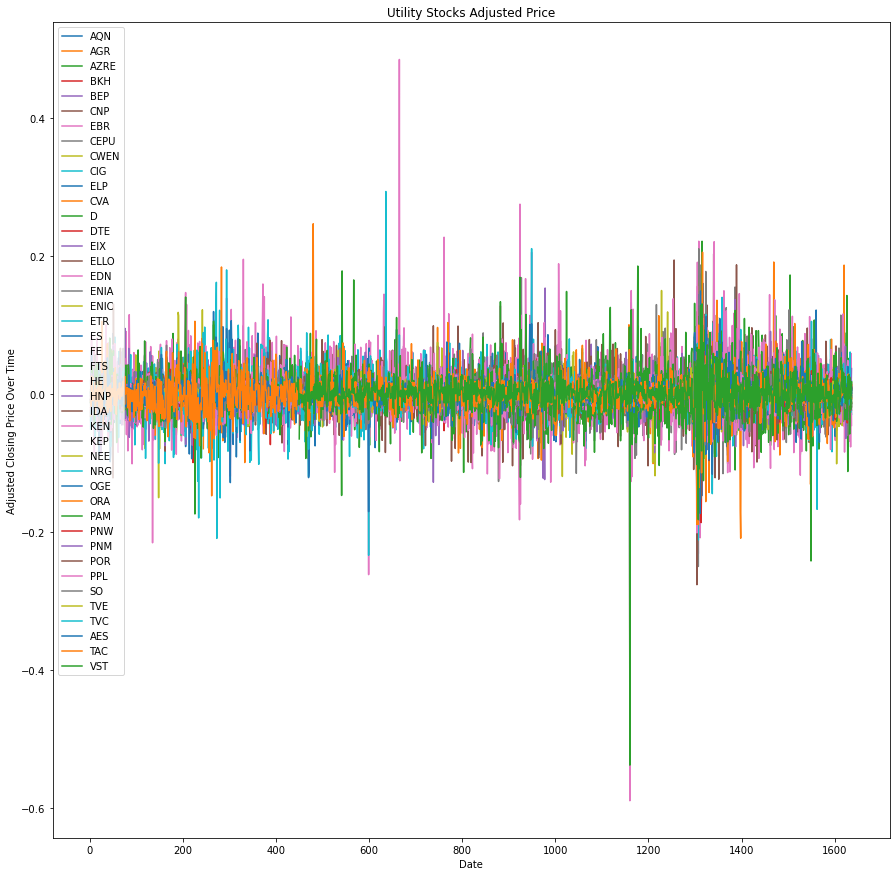

In [6]:
srr = adjusted_close.astype(float).pct_change()

srr.plot(figsize=(15,15))
plt.ylabel('Adjusted Closing Price Over Time')
plt.xlabel('Date')
plt.title('Utility Stocks Adjusted Price')

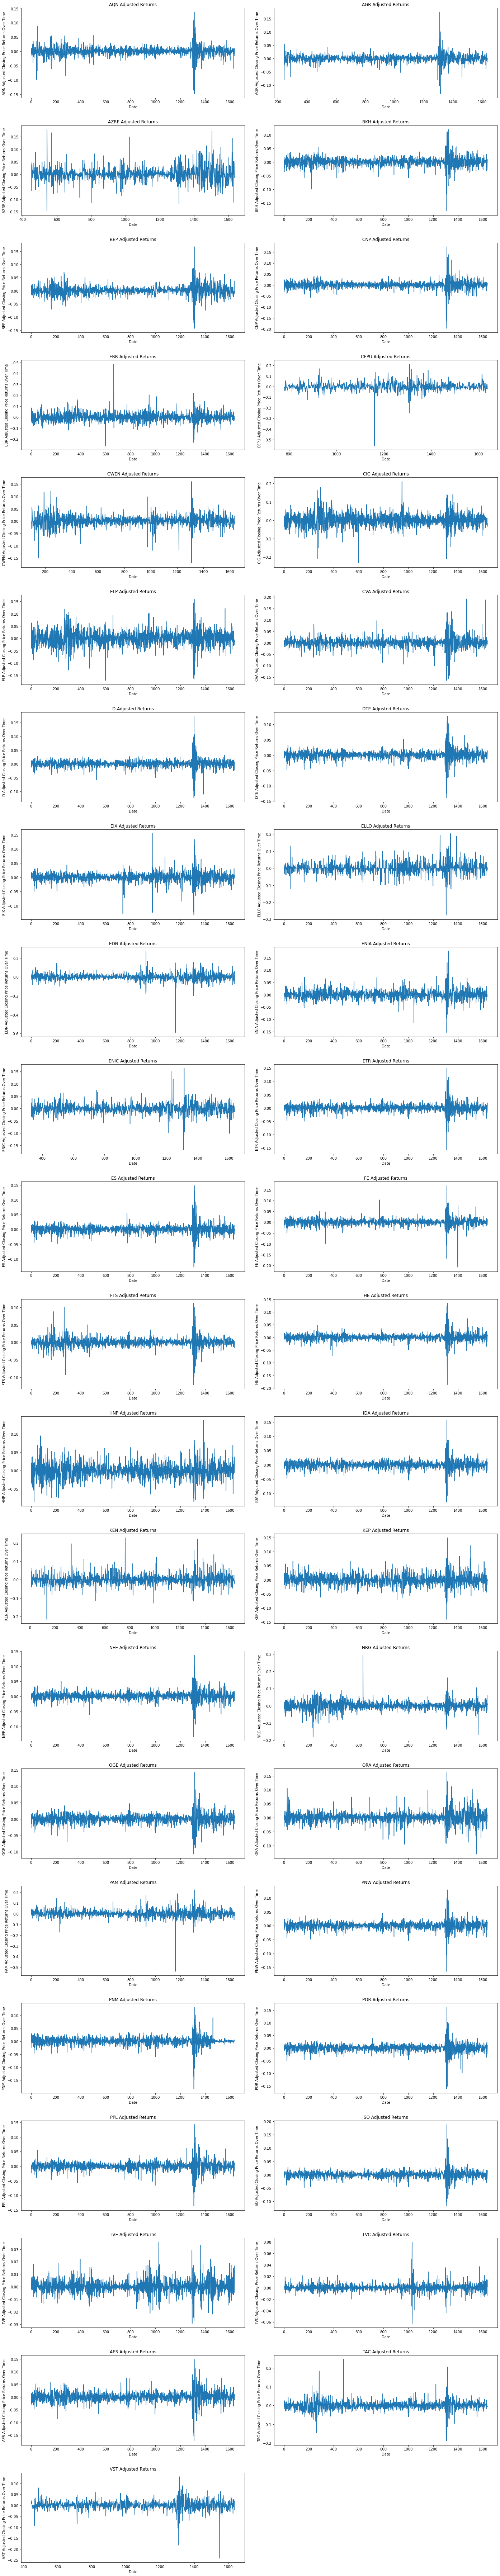

In [7]:
plt.figure(figsize=(20, 200))
for i in range(len(symbols)):
    plt.subplot(len(symbols)+1,2, i+1)
    plt.tight_layout(pad=3.0)
    srr[symbols[i]].plot()
    plt.ylabel(symbols[i] + ' Adjusted Closing Price Returns Over Time')
    plt.xlabel('Date')
    plt.title(symbols[i] + ' Adjusted Returns')

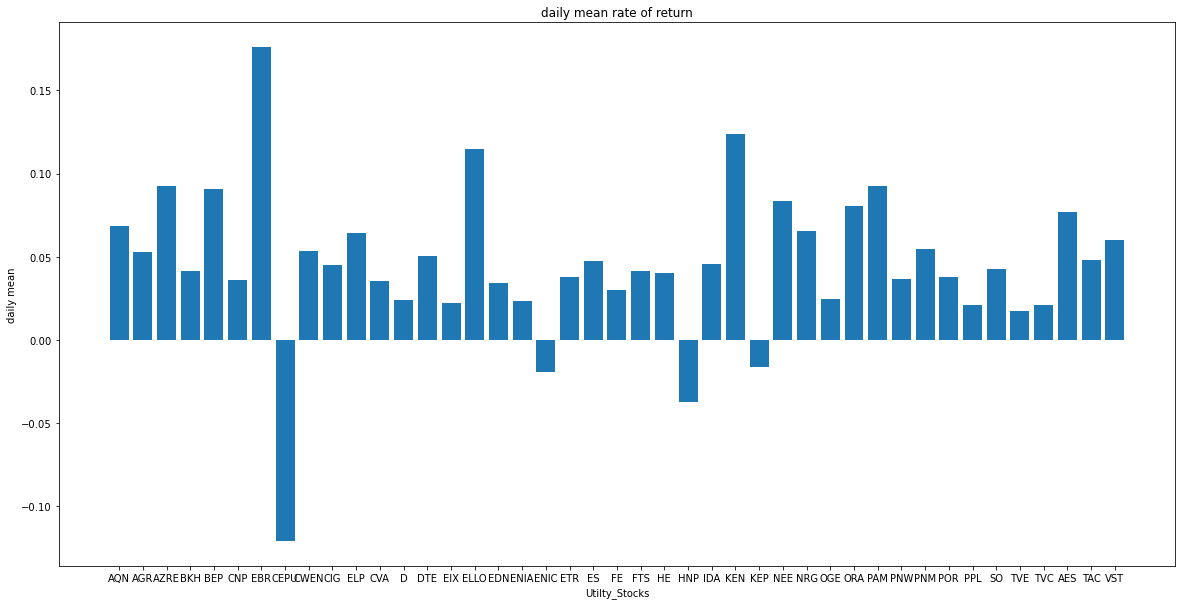

In [8]:

srr_mean = srr.mean()*100
height = []
for key in srr_mean.keys():
   height.append(srr_mean[key]) 
x_pos = np.arange(len(srr_mean.keys()))

plt.figure(figsize = (20,10))
plt.bar(x_pos, height)

# create names on the x-axis
plt.xticks(x_pos, srr_mean.keys())

# label chart
plt.xlabel("Utilty_Stocks")
plt.ylabel("daily mean")
plt.title("daily mean rate of return")

# show graphic
plt.show()

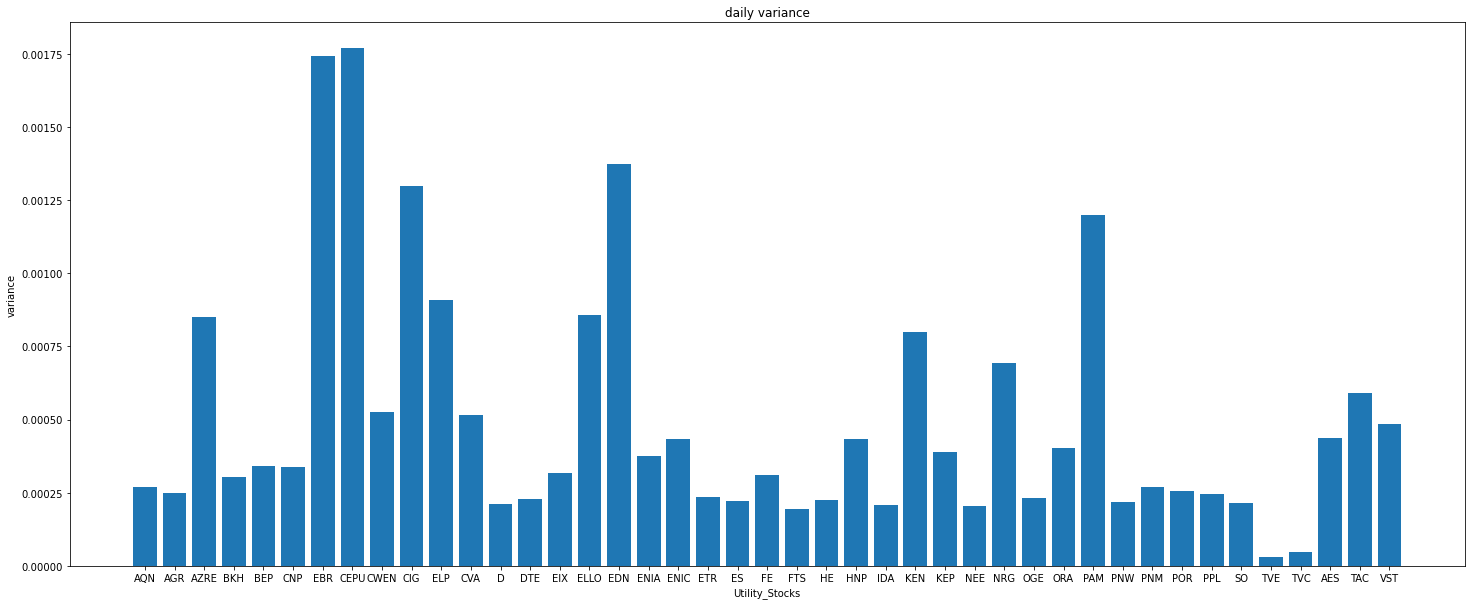

In [9]:
srr_cov = srr.cov()
srr_var = srr.var()
height = []
for key in srr_var.keys():
    height.append(srr_var[key])
x_pos = np.arange(len(srr_var.keys()))

# plot bars
plt.figure(figsize = (25,10))
plt.bar(x_pos, height)
 
# create names on the x-axis
plt.xticks(x_pos, srr_var.keys())

# label chart
plt.xlabel("Utility_Stocks")
plt.ylabel("variance")
plt.title("daily variance")

# show graphic
plt.show()

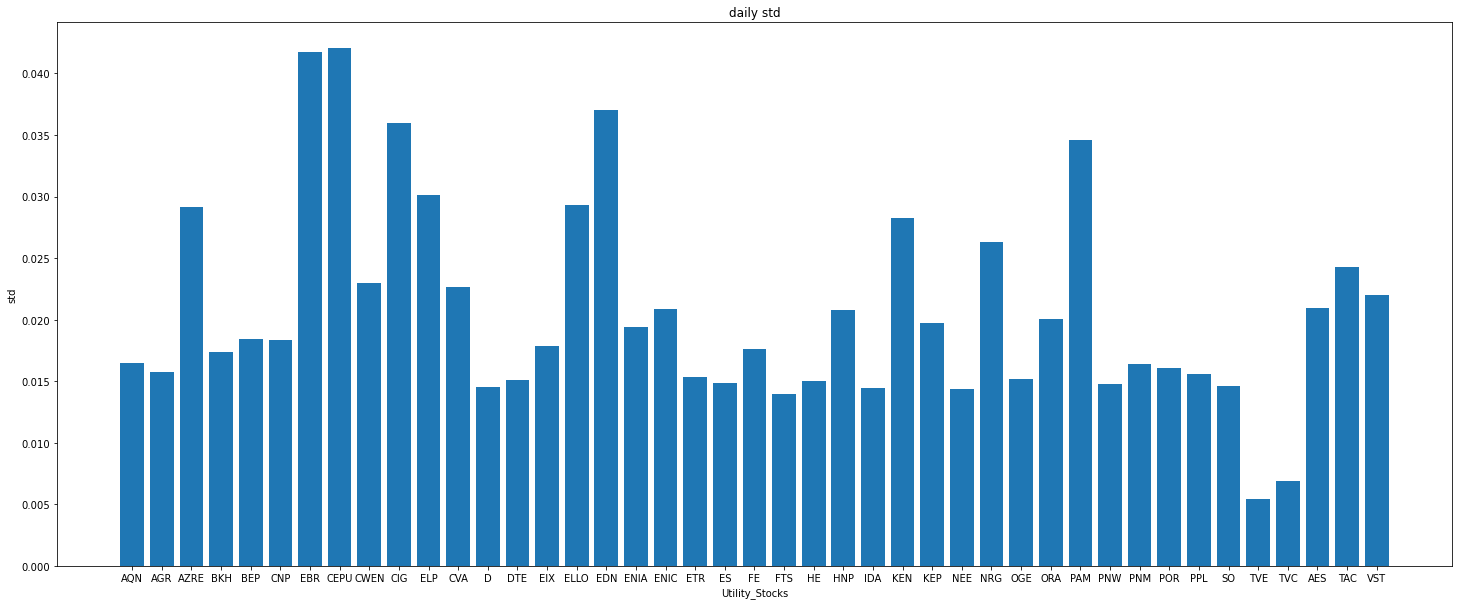

In [10]:
srr_std = srr.std()
srr_std.keys()
height = []
for key in srr_std.keys():
    height.append(srr_std[key])
x_pos = np.arange(len(srr_std.keys()))

# plot bars
plt.figure(figsize = (25,10))
plt.bar(x_pos, height)
 
# create names on the x-axis
plt.xticks(x_pos, srr_std.keys())

# label chart
plt.xlabel("Utility_Stocks")
plt.ylabel("std")
plt.title("daily std")

# show graphic
plt.show()

In [11]:
srr.corr()

,AQN,AGR,AZRE,BKH,BEP,CNP,EBR,CEPU,CWEN,CIG,...,PNW,PNM,POR,PPL,SO,TVE,TVC,AES,TAC,VST
AQN,1.000000,0.536045,0.026787,0.475695,0.577833,0.488060,0.278314,0.253486,0.388901,0.328147,...,0.504108,0.473478,0.458680,0.470268,0.494757,0.063909,0.114525,0.439103,0.476461,0.399861
AGR,0.536045,1.000000,0.013355,0.600827,0.388055,0.574795,0.235512,0.136602,0.387950,0.284904,...,0.643122,0.545012,0.669011,0.624826,0.694191,0.026301,0.094664,0.388572,0.321133,0.313158
AZRE,0.026787,0.013355,1.000000,0.022966,0.137417,0.037558,0.015220,0.092943,0.106212,0.004176,...,0.000062,-0.010935,-0.015776,0.015033,0.006362,-0.007028,0.016279,0.064621,0.097363,-0.001384
BKH,0.475695,0.600827,0.022966,1.000000,0.398847,0.712495,0.299020,0.197279,0.430652,0.344768,...,0.792107,0.738217,0.727180,0.700255,0.708076,0.073501,0.144620,0.603538,0.334570,0.440882
BEP,0.577833,0.388055,0.137417,0.398847,1.000000,0.459813,0.255365,0.229705,0.372088,0.270208,...,0.399641,0.375355,0.325351,0.391024,0.381601,0.089521,0.088796,0.431045,0.488536,0.295409
CNP,0.488060,0.574795,0.037558,0.712495,0.459813,1.000000,0.306373,0.226979,0.438706,0.364751,...,0.722727,0.665837,0.652001,0.702080,0.675230,0.054460,0.145543,0.603201,0.417637,0.433160
EBR,0.278314,0.235512,0.015220,0.299020,0.255365,0.306373,1.000000,0.342432,0.210330,0.639631,...,0.256852,0.265085,0.263030,0.276297,0.234105,0.006982,0.074986,0.292228,0.274754,0.253108
CEPU,0.253486,0.136602,0.092943,0.197279,0.229705,0.226979,0.342432,1.000000,0.185161,0.305838,...,0.189940,0.182538,0.126299,0.174096,0.143669,0.015137,0.098728,0.262568,0.253770,0.219553
CWEN,0.388901,0.387950,0.106212,0.430652,0.372088,0.438706,0.210330,0.185161,1.000000,0.279017,...,0.404766,0.363299,0.348771,0.367259,0.347478,0.071572,0.067767,0.467230,0.341661,0.329474
CIG,0.328147,0.284904,0.004176,0.344768,0.270208,0.364751,0.639631,0.305838,0.279017,1.000000,...,0.327502,0.316402,0.302862,0.325656,0.290168,0.047631,0.092768,0.381427,0.297899,0.286741


In [23]:
#Borrowing code from efficient frontier exercise
def return_portfolios(expected_returns, cov_matrix):
    port_returns = []
    port_volatility = []
    stock_weights = []
    
    selected = (expected_returns.axes)[0]
    
    num_assets = len(selected) 
    num_portfolios = 5000
    
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, expected_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
    
    portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility}
    
    for counter,symbol in enumerate(selected):
        portfolio[symbol +' Weight'] = [Weight[counter] for Weight in stock_weights]
    
    df = pd.DataFrame(portfolio)
    
    column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in selected]
    
    df = df[column_order]
   
    return df
  
def optimal_portfolio(returns):
    n = returns.shape[1]
    print('n is: ', n)
    returns = np.transpose(returns.values)

    N = 100
    mus = [10**(6.0 * t/N - 1.0) for t in range(N)]
    print('\n mus is:', mus)
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    print('\n s is:', '\nPbar is: ', pbar)
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    print('\n G is:', G, '\n h is: ', h, '\n A is', A, '\n b is', b)
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

In [24]:
portfolio_df = return_portfolios(srr_mean, srr_cov)
weights, returns, risks = optimal_portfolio(srr[1:])

n is:  43

 mus is: [0.1, 0.1148153621496883, 0.1318256738556407, 0.1513561248436208, 0.17378008287493754, 0.19952623149688797, 0.2290867652767773, 0.26302679918953814, 0.3019951720402016, 0.34673685045253166, 0.3981071705534972, 0.4570881896148751, 0.5248074602497725, 0.6025595860743578, 0.6918309709189364, 0.7943282347242815, 0.9120108393559097, 1.0471285480508996, 1.2022644346174132, 1.3803842646028845, 1.5848931924611134, 1.8197008586099834, 2.0892961308540396, 2.39883291901949, 2.7542287033381663, 3.1622776601683795, 3.630780547701014, 4.168693834703355, 4.786300923226383, 5.495408738576246, 6.309573444801933, 7.2443596007499025, 8.317637711026709, 9.549925860214358, 10.964781961431852, 12.589254117941675, 14.45439770745928, 16.595869074375614, 19.054607179632463, 21.87761623949552, 25.118864315095795, 28.84031503126606, 33.11311214825911, 38.018939632056124, 43.65158322401661, 50.11872336272725, 57.543993733715666, 66.06934480075958, 75.85775750291836, 87.09635899560806, 100.0, 1

ValueError: Rank(A) < p or Rank([P; A; G]) < n

In [ ]:
srr